In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns

plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

In [2]:
# задаём константы для графиков
BIG_SIZE = 12
MEDIUM_SIZE = 10
SMALL_SIZE = 8

In [3]:
# Загружаем данные
power_10 = pd.read_csv('10_percent.csv').rename(columns={'1': "seconds", '42': "temperature"})
power_15 = pd.read_csv('15_percent.csv').rename(columns={'1': "seconds", '43': "temperature"})
power_20 = pd.read_csv('20_percent.csv').rename(columns={'1': "seconds", '34': "temperature"})
power_25 = pd.read_csv('25_percent.csv').rename(columns={'1': "seconds", '22': "temperature"})
power_30 = pd.read_csv('30_percent.csv').rename(columns={'1': "seconds", '48': "temperature"})
power_35 = pd.read_csv('35_percent.csv').rename(columns={'1': "seconds", '57': "temperature"})
power_40 = pd.read_csv('40_percent.csv').rename(columns={'1': "seconds", '69': "temperature"})

# Cоздаём новый столбец- мощность
power_10['power'] = 10
power_15['power'] = 15
power_20['power'] = 20
power_25['power'] = 25
power_30['power'] = 30
power_35['power'] = 35
power_40['power'] = 40

# Объединяем данные
melt_df = pd.concat([power_10, power_15, power_20, power_25, power_30, power_35, power_40], ignore_index=True)

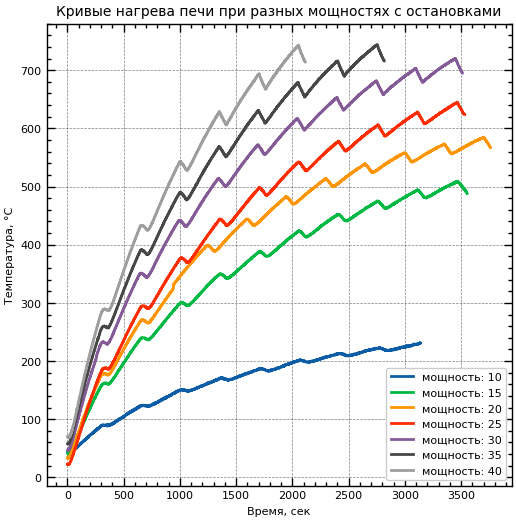

In [4]:
# Разделяем данные по столбцам
pivot_df = melt_df.groupby(['seconds', 'power'])['temperature'].mean().unstack('power')

# Создаём фигуру и настраиваем отступы для графиков
fig, axes = plt.subplots(figsize=(6, 6))

axes.plot(pivot_df.index, pivot_df[10], label='мощность: 10')
axes.plot(pivot_df.index, pivot_df[15], label='мощность: 15')
axes.plot(pivot_df.index, pivot_df[20], label='мощность: 20')
axes.plot(pivot_df.index, pivot_df[25], label='мощность: 25')
axes.plot(pivot_df.index, pivot_df[30], label='мощность: 30')
axes.plot(pivot_df.index, pivot_df[35], label='мощность: 35')
axes.plot(pivot_df.index, pivot_df[40], label='мощность: 40')

# Добавляем подписи на оси
axes.set_xlabel('Время, сек', fontsize=SMALL_SIZE)
axes.set_ylabel('Температура, °С', fontsize=SMALL_SIZE)
# Добавляем заголовок
axes.set_title('Кривые нагрева печи при разных мощностях с остановками', fontsize=MEDIUM_SIZE)
# Настраиваем размер легенды и подписей осей
axes.legend(loc='lower right', fontsize=SMALL_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

plt.show()

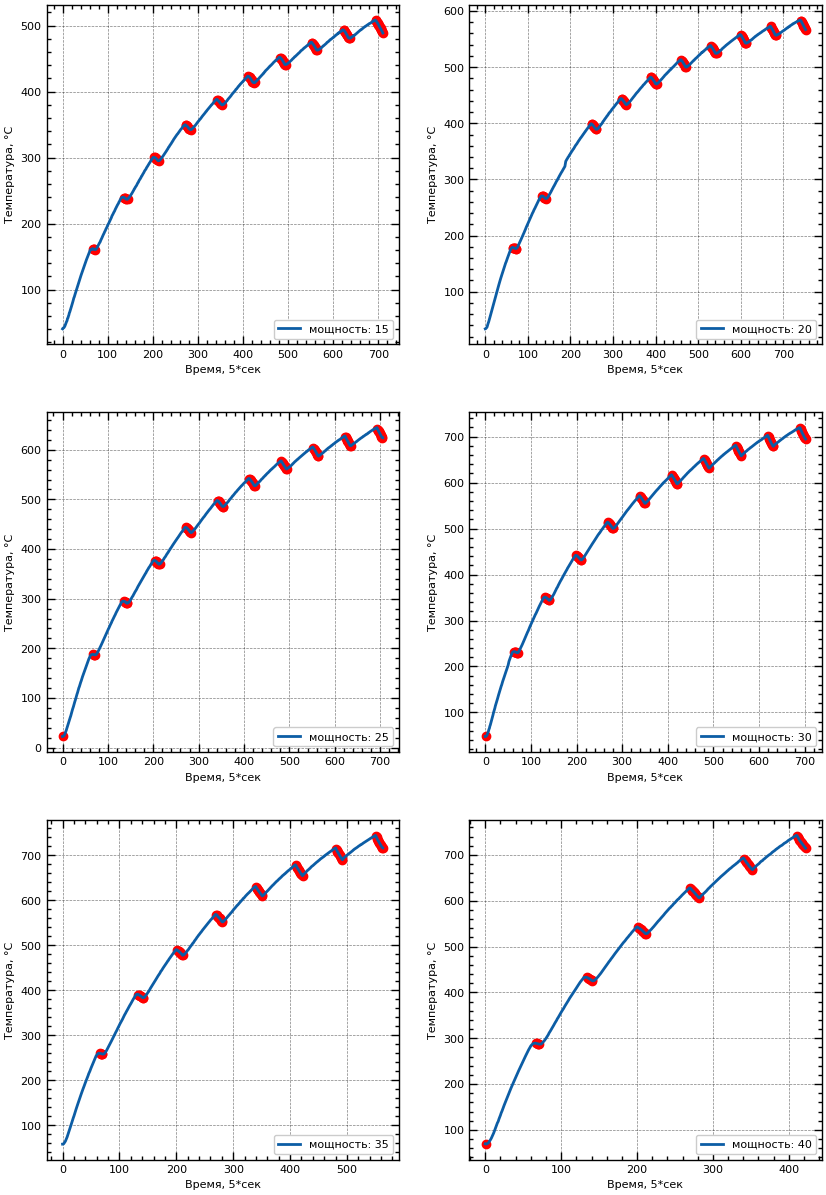

In [5]:
# Группируем данные по 5 секунд и вычисляем среднее значение
df_grouped = pivot_df.groupby(pivot_df.index // 5).agg(
    {10: 'mean',
     15: 'mean',
     20: 'mean',
     25: 'mean',
     30: 'mean',
     35: 'mean',
     40: 'mean',     
     })
# Переводим таблицу в "длинный" формат, 
# чтобы каждый ряд содержал только одну температуру и соответствующую ей мощность
df = df_grouped.melt().rename(columns={'value':'temperature'})

# Выделяем строки, содержащие значение 10 в столбце power
index_names = df[df['power'] == 10].index

# Удаляем строки, содержащие значение 10 в столбце power
df.drop(index_names, inplace=True)

# Определяем, было ли охлаждение по сравнению с предыдущей температурой 
# и создаем столбец cooling
df['cooling'] = df['temperature'].diff() < 0

# Сбрасываем индекс и переименовываем столбец
df = df.reset_index(names='time')

# Инициализируем пустой список для сохранения времени начала охлаждения 
# и номер группы чтобы в дальнейшем периоды охлаждения различать между собой
value_stack = []
group_number = 0

# Функция для присваивания номера группы периода охлаждения
def assign_group_number(time):    
    global value_stack
    global group_number
    
    # Если список пустой, добавляем текущее время
    if len(value_stack) == 0:
        value_stack.append(time)
    # Если время между текущим и предыдущим меньше или равно 3, добавляем текущее время в список
    elif time - value_stack.pop() <= 3:
        value_stack.append(time)
    # Иначе увеличиваем номер группы и начинаем новый список с текущего времени
    else:
        group_number += 1
        value_stack = [time]
    return group_number

# Создаем новый столбец cooling_group, который содержит номер группы 
# для каждого времени, когда было охлаждение
df['cooling_group'] = df.query('cooling == True')['time'].apply(assign_group_number)

# Получаем список мощностей для дальнейшей работы
powers_list = df['power'].value_counts().index.to_list()

# После применения метода melt() время экспериментов объединилось в один
# непрерывный столбец. Устанавливаем начало каждого эксперимента на 0.
for power in powers_list:
    query = f'power == {power}'
    df.loc[df.eval(query), 'time'] = df.loc[df.eval(query), 'time'] - df.loc[df.eval(query), 'time'].min()
    
# Создаём фигуру с 6 графиками
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))

for i in range(3):
    for j in range(2):
        # Устанавливаем значение мощности для графика
        N_POWER = powers_list[i*2+j]
        
        # Создаём запросы к данным для графика
        query = f'power == {N_POWER}'
        scatter_query = f'cooling == True and power == {N_POWER}'
        
        # Строим график и подсвечиваем точки, которые считаем охлаждением
        # для мощности N_POWER 
        axes[i][j].plot(df.query(query)['time'], df.query(query)['temperature'], label=f'мощность: {N_POWER}')
        axes[i][j].scatter(df.query(scatter_query)['time'], df.query(scatter_query)['temperature'],  color='red')
        
        # Добавляем подписи на оси и настраиваем размер 
        # легенды и подписей осей 
        axes[i][j].set_xlabel('Время, 5*сек', fontsize=SMALL_SIZE)
        axes[i][j].set_ylabel('Температура, °С', fontsize=SMALL_SIZE)
        axes[i][j].legend(loc='lower right', fontsize=SMALL_SIZE)
        axes[i][j].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

Предположим, что скорость остывания зависит от температуры так, что каждый новый градус разницы вносит свой вклад в убывание энергии, тогда в дифференциальном виде уравнение будет записано:
$$ y = xdx $$
А его решением будет:
$$ y = ax^2 + c$$


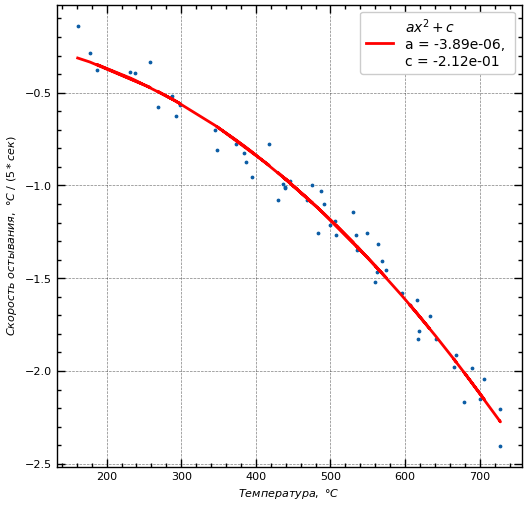

In [6]:
# Устанавливаем значение 'False' для столбца 'cooling' в тех строках,
# где значение температуры меньше 100
df.loc[df.eval('temperature < 100'), 'cooling'] = False

# Устанавливаем значение NaN для столбца 'cooling_group' в тех строках, 
# где значение температуры меньше 100
df.loc[df.eval('temperature < 100'), 'cooling_group'] = np.nan

# Получаем список уникальных групп остывания и сортируем их по возрастанию
cooling_group_list = df['cooling_group'].value_counts().index.sort_values().to_list()

# Для каждой группы остывания вычисляем коэффициент наклона линейной регрессии 
# между временем и температурой
for group in cooling_group_list:
    # Создаем строку запроса для выборки данных, относящихся к текущей группе остывания
    query = f'cooling_group == {group}'
    
    # Выбираем значения времени и температуры для текущей группы остывания
    x = df.loc[df.eval(query), 'time']
    y = df.loc[df.eval(query), 'temperature']
    
    # Вычисляем коэффициент наклона линейной регрессии для текущей группы остывания 
    # и записываем его в столбец 'cooling_k'
    df.loc[df.eval(query), 'cooling_k'] = np.polyfit(x,y,1)[0]

# Группируем данные по коэффициенту наклона линейной регрессии 
# и находим среднее значение температуры для каждой группы
df_ = df.groupby('cooling_k')['temperature'].mean().reset_index()

# Определяем функцию для аппроксимации данных
def quadratic_func(x, a, c):
        return a*x**2 + c

# Используем функцию curve_fit для аппроксимации данных
cooling_coeffs, pcov = curve_fit(quadratic_func, df_['temperature'], df_['cooling_k'])

# Получаем значения параметров аппроксимирующей функции
a, c = cooling_coeffs

# Вычисляем значения аппроксимирующей функции для данных температуры
y = quadratic_func(df_['temperature'], a, c)

# Создаём фигуру и оси для графика
fig, axes = plt.subplots(figsize=(6, 6))

# Отображаем точки на графике
axes.scatter(df_['temperature'], df_['cooling_k'], s=3)

# Отображаем кривую аппроксимации на графике
axes.plot(df_['temperature'], y, color='red',
          label=r'$a x^2 + c$' + ' \na = {:.2e}, \nc = {:.2e}'.format(a, c))

# Добавляем подписи на оси и настраиваем размер легенды и подписей осей 
axes.set_xlabel('$Температура,~°С$', fontsize=SMALL_SIZE)
axes.set_ylabel('$Скорость~остывания,~°С~/~(5*сек)$', fontsize=SMALL_SIZE)
axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# Отображаем график
plt.show()

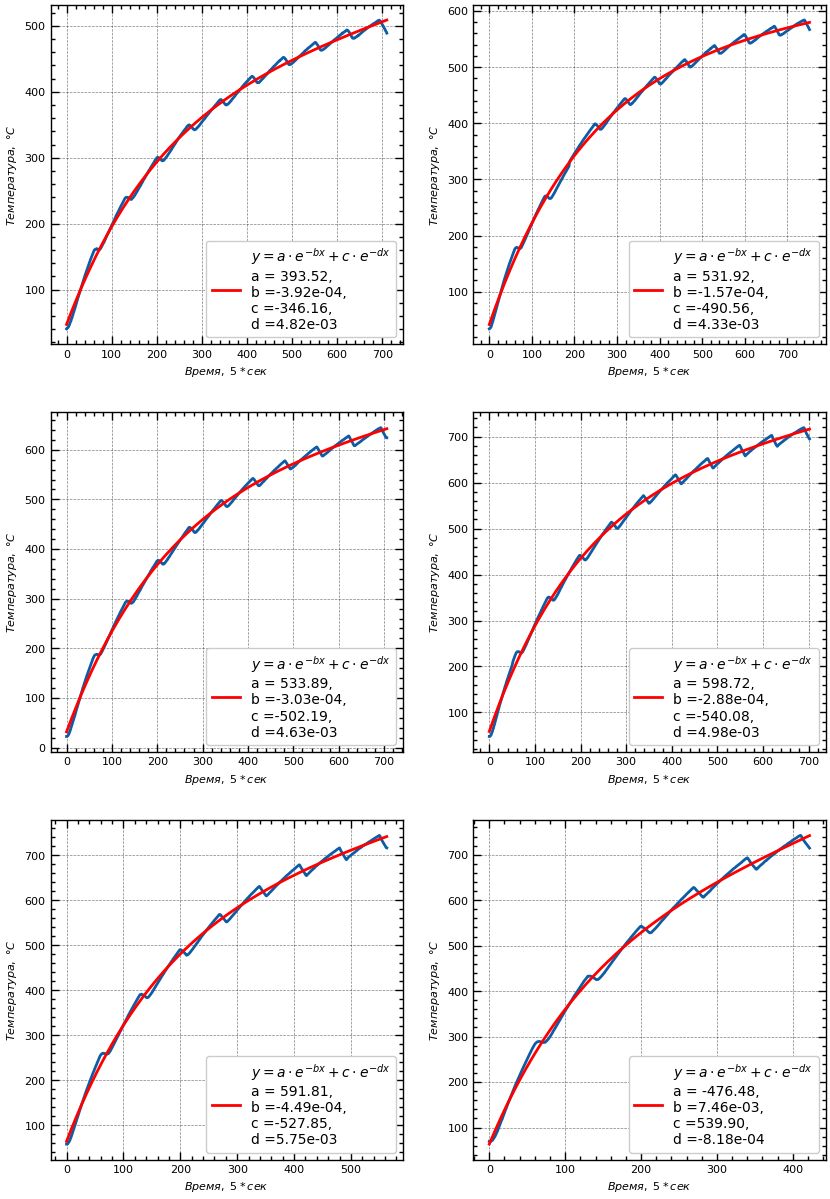

In [7]:
def double_exponential_func(x, a, b, c, d):
    return a * np.exp(-b * x) + c*np.exp(-d * x)

# Создаём пустой DataFrame для коэффициентов аппроксимации
coeffs = pd.DataFrame(index=['a','b','c','d'])

# Создаём фигуру с 6 графиками
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))

for i in range(3):
    for j in range(2):
        # Устанавливаем значение мощности для графика
        N_POWER = powers_list[i*2+j]
        # Создаём запросы к данным для графика
        query = f'power == {N_POWER}'
        
        data = df.query(query)['temperature'].dropna()

        # Используем функцию double_exponential_func для аппроксимации данных
        popt, pcov = curve_fit(double_exponential_func, range(len(data)), data, p0=(400, 0, -400, 0), maxfev=10000)

        # Добавляем коэффициенты аппроксимации в DataFrame
        coeffs[N_POWER] = popt

        # Отображаем точки на графике
        axes[i][j].plot(range(len(data)), data)

        # Отображаем аппроксимированную функцию на графике и добавляем легенду
        axes[i][j].plot(range(len(data)), double_exponential_func(range(len(data)), *popt), 'r-',
                label='$y = a \cdot e^{-b x} + c \cdot e^{-d x}$' + ' \na = {:.2f}, \nb ={:.2e}, \nc ={:.2f}, \nd ={:.2e}'
                .format(popt[0], popt[1], popt[2], popt[3]))

        # Добавляем подписи на оси и настраиваем размер легенды и подписей осей 
        axes[i][j].set_xlabel('$Время,~5*сек$', fontsize=SMALL_SIZE)
        axes[i][j].set_ylabel('$Температура,~°С$', fontsize=SMALL_SIZE)
        axes[i][j].legend(loc='lower right', fontsize=MEDIUM_SIZE)
        axes[i][j].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

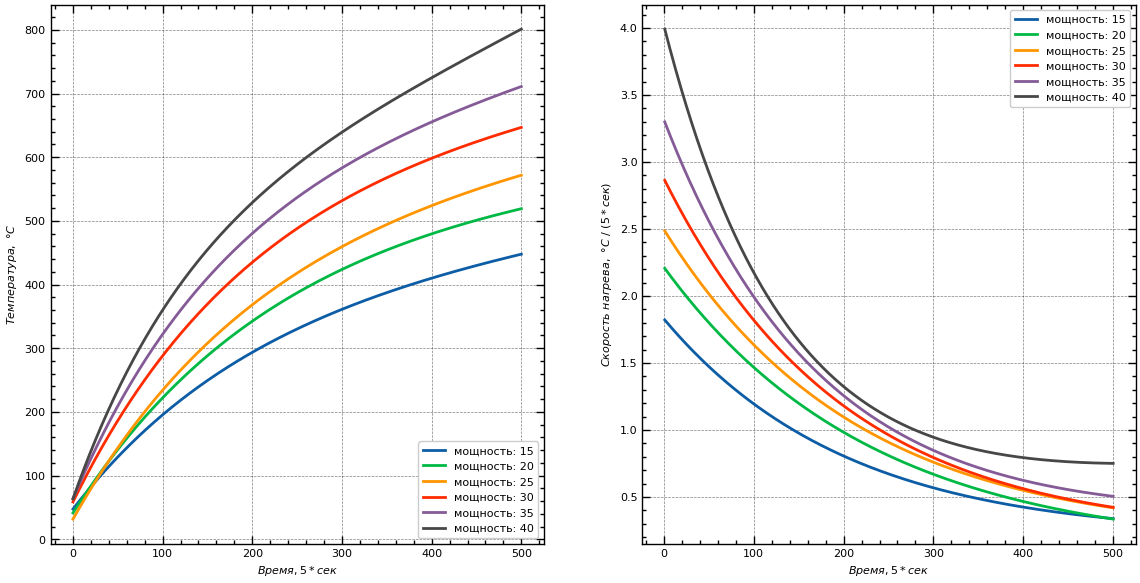

In [8]:
# Создаём фигуру
fig, axes = plt.subplots(ncols=2, figsize=(14, 7))

# Создаём массив значений для x в заданном диапазоне
x = np.linspace(0, 500, 500)

# Создаём пустой DataFrame для хранения результатов вычислений
diff_df = pd.DataFrame(index=x)

# Вычисляем значения для каждой мощности в списке powers_list
for power in powers_list:
    # Вычисляем значения функции для каждой мощности
    diff_df[power] = double_exponential_func(
        x, coeffs[power]['a'], coeffs[power]['b'], coeffs[power]['c'], coeffs[power]['d'])
    
    # Рисуем график температуры для каждой мощности на первой графической области
    axes[0].plot(diff_df.index, diff_df[power].values, label=f'мощность: {power}')
    
    # Вычисляем производную от температуры и заменяем результаты в DataFrame
    diff_df[power] = diff_df[power].diff()
    
    # Рисуем график скорости нагрева для каждой мощности на второй графической области
    axes[1].plot(diff_df.index, diff_df[power].values, label=f'мощность: {power}')
    
# Добавляем подписи на оси и настраиваем размер легенды и подписей осей на первой графической области
axes[0].set_xlabel('$Время, 5*сек$', fontsize=SMALL_SIZE)
axes[0].set_ylabel('$Температура,~°С$', fontsize=SMALL_SIZE)
axes[0].legend(loc='lower right', fontsize=SMALL_SIZE)
axes[0].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# Добавляем подписи на оси и настраиваем размер легенды и подписей осей на второй графической области
axes[1].set_xlabel('$Время, 5*сек$', fontsize=SMALL_SIZE)
axes[1].set_ylabel('$Скорость~нагрева,~°С~/~(5*сек)$', fontsize=SMALL_SIZE)
axes[1].legend(loc='upper right', fontsize=SMALL_SIZE)
axes[1].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)


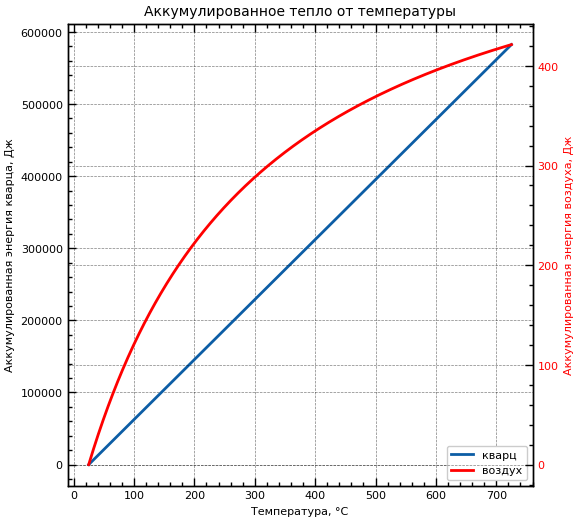

In [9]:
# задаем параметры печи, трубы и заглушки
OVEN_DIAMETER = 105  # диаметр печи в миллиметрах
OVEN_LENGTH = 495  # длина печи в миллиметрах
PIPE_DIAMETER = 80  # диаметр трубы в миллиметрах
PIPE_WIDTH = 4  # толщина стенок трубы в миллиметрах
PLUG_LENGTH = 40  # длина заглушки трубы в миллиметрах

# функция для расчета объема цилиндра по его диаметру и длине
def cylinder_volume(diameter, length):
    radius = diameter / 2  # вычисляем радиус по диаметру
    volume = np.pi * radius ** 2 * length  # вычисляем объем цилиндра по формуле V = πr^2h
    return volume

# функция для перевода объема из кубических миллиметров в кубические сантиметры
def mm3_to_cm3(volume):
    cm3 = volume / 1000  # делим объем на 1000, чтобы перевести в кубические сантиметры
    return cm3

# вычисляем объем печи
oven_volume = mm3_to_cm3(cylinder_volume(OVEN_DIAMETER, OVEN_LENGTH))

# вычисляем объем асбестовой изоляции
asbestos_volume = oven_volume - mm3_to_cm3(cylinder_volume(PIPE_DIAMETER, OVEN_LENGTH))

# вычисляем объем заглушки трубы
plug_volume = mm3_to_cm3(cylinder_volume((PIPE_DIAMETER- 2*PIPE_WIDTH), PLUG_LENGTH))

# вычисляем объем воздушного пространства внутри трубы
air_volume = mm3_to_cm3(cylinder_volume((PIPE_DIAMETER- 2*PIPE_WIDTH), OVEN_LENGTH)) - 2 * plug_volume

# вычисляем объем кварцевой трубы
pipe_volume = oven_volume - air_volume - 2*plug_volume - asbestos_volume

# согласно источникам в интернете
properties = pd.DataFrame({
    'плотность': [1.200, 2.200, 0.100, np.nan],  # Кг / М**3
    'теплоемкость': [816, 800, 1050, 1007],  # Дж / Кг*К
    'теплопроводность': [0.06, 1.38, 0.18, 0.023]
    },
    index=['асбест', 'кварц', 'каолиновая_вата', 'воздух'])

# функция для расчета массы воздуха в трубе при заданной температуре
def mass_of_air(volume_cm3, temperature):    
    R = 8.314
    M = 0.02897
    P = 101325  # стандартное атмосферное давление в Па
    volume_m3 = volume_cm3 / 1000000  # перевод в метры кубические
    n = (P * volume_m3) / (R * (temperature + 273.15))
    return n * M * 1000  # перевод массы в граммы

# создаем массив температур, на которых будем считать массу воздуха и объем кварцевой трубы
temperature = np.linspace(25, 725, 700)

# считаем массу воздуха в трубе и вычисляем аккумулированную энергию воздуха
air_mass = mass_of_air(air_volume, temperature) / 1000 # в килограммах
air_absorbed_heat = air_mass * properties['теплоемкость']['воздух'] * (temperature - temperature.min()) # в Дж

# вычисляем массу кварцевой трубы и аккумулированную энергию трубы
pipe_mass = properties['плотность']['кварц'] * pipe_volume / 1000 # в килограммах
pipe_absorbed_heat = pd.Series(pipe_mass * properties['теплоемкость']['кварц'] * (temperature - temperature.min())) # в Дж

# Создаём фигуру и настраиваем отступы для графиков
fig, axes = plt.subplots(figsize=(6, 6))

# Строим график кварца на основном axes
axes.plot(temperature, pipe_absorbed_heat, label='кварц')

# Создаем новый объект axes для воздуха и настраиваем его масштаб
ax2 = axes.twinx()

# Строим график воздуха на новой оси
ax2.plot(temperature, air_absorbed_heat, label='воздух', color='r')

# Добавляем подписи на оси
axes.set_xlabel('Температура, °С', fontsize=SMALL_SIZE)
axes.set_ylabel('Аккумулированная энергия кварца, Дж', fontsize=SMALL_SIZE)

# Добавляем подписи на оси новой оси y
ax2.set_ylabel('Аккумулированная энергия воздуха, Дж', fontsize=SMALL_SIZE, color='r')
ax2.tick_params(axis='y', labelcolor='r', which='both', labelsize=SMALL_SIZE)

# Настраиваем размер легенды и подписей осей
handles, labels = axes.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
axes.legend(handles+handles2, labels+labels2, loc='lower right', fontsize=SMALL_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# Добавляем заголовок
axes.set_title('Аккумулированное тепло от температуры', fontsize=MEDIUM_SIZE)

plt.show()


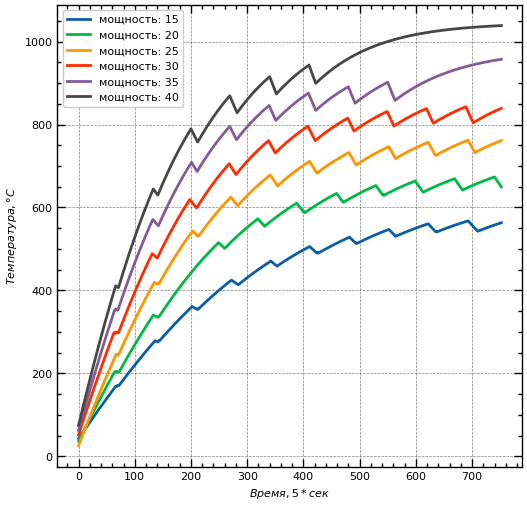

In [10]:
OVEN_RESISTANCE = 19 # Ом - сопротивление печи
MAINS_VOLTAGE = 230 # Вольт - напряжение в сети
LOSSES_CONST = 0 # Ватт

# согласно литературному источнику literature/sergeev1982
def quartz_heat_capacity(temperature):    
    return 931.3 + 0.256*temperature - 24*temperature**(-2)

# Функция расчета потери энергии из-за охлаждения
def energy_loss(temperature):
    temperature_loss = cooling_coeffs[0]*temperature**2 + cooling_coeffs[1]
    return pipe_mass * quartz_heat_capacity(temperature) * temperature_loss

# Функция для расчета изменения температуры
def get_dt(heat_flow):
    global t_stack
    t = t_stack.pop()
    dt = (heat_flow + energy_loss(t) - LOSSES_CONST) / quartz_heat_capacity(t)
    t_stack.append(t+dt)
    return t+dt

# Расчет тока и теплового потока для каждой мощности
df['amperage'] = (MAINS_VOLTAGE/OVEN_RESISTANCE) * df['power'] / 100
df['heat_flow'] = np.where((df['cooling'] == True), 0, df['amperage'] * MAINS_VOLTAGE * 5)

# Создание фигуры с графиками
fig, axes = plt.subplots(figsize=(6, 6))

# Цикл по списку мощностей и построение графиков
for power in powers_list:
    # Создаем строку запроса для фильтрации данных по текущей мощности
    query = f'power == {power}'
    
    # Получаем минимальную температуру для текущей мощности и добавляем ее в стек температур
    t_stack = [df.query(query)['temperature'].min(),]
    
    # Рассчитываем изменение температуры для каждого значения теплового потока в DataFrame с текущей мощностью
    df.loc[df.eval(query), 'calc_t'] = df.loc[df.eval(query), 'heat_flow'].apply(get_dt)
    
    # Строим график изменения температуры для текущей мощности
    axes.plot(range(len(df.loc[df.eval(query), 'calc_t'].values)), 
              df.loc[df.eval(query), 'calc_t'].values, 
              label=f'мощность: {power}')


# Добавление подписей к осям и настройка размера легенды и подписей осей
axes.set_xlabel('$Время, 5*сек$', fontsize=SMALL_SIZE)
axes.set_ylabel('$Температура, °С$', fontsize=SMALL_SIZE)
axes.legend(loc='upper left', fontsize=SMALL_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)


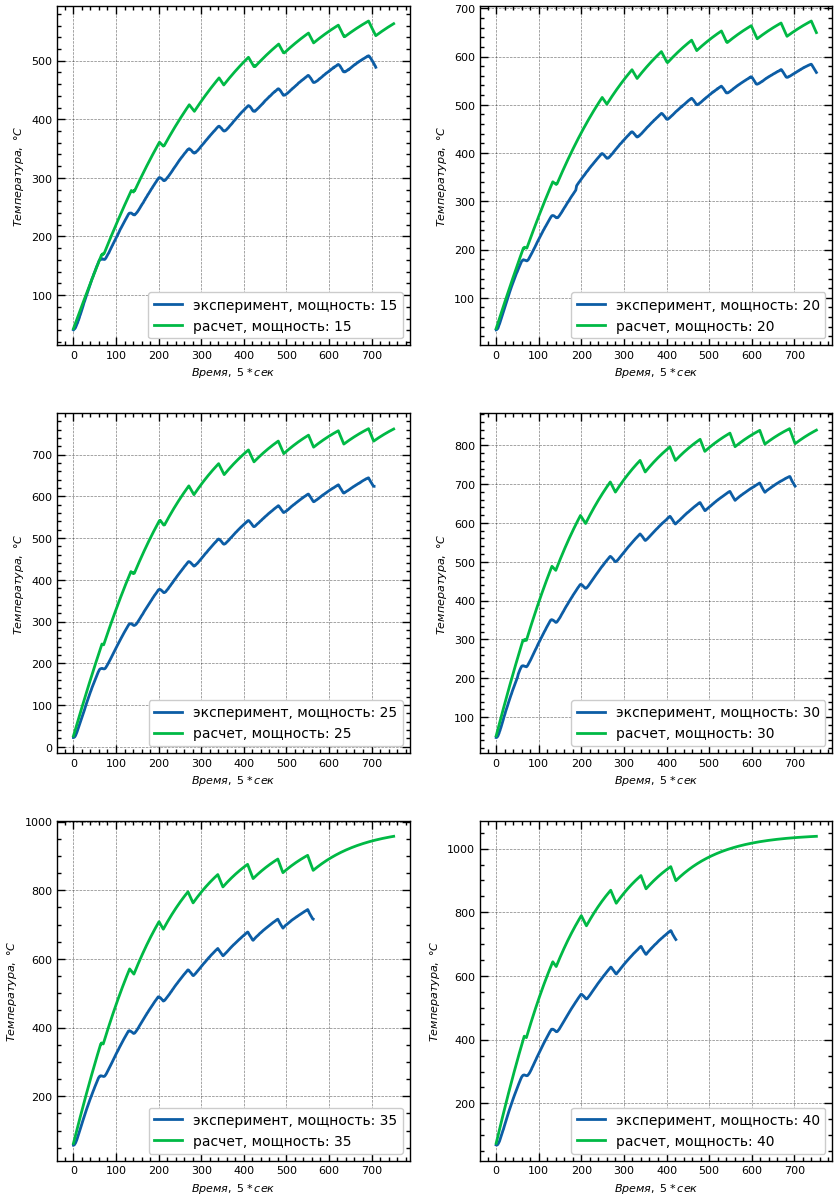

In [11]:
# Создаём фигуру с 6 графиками
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))

for i in range(3):
    for j in range(2):
        # Устанавливаем значение мощности для графика
        N_POWER = powers_list[i*2+j]
        # Создаём запросы к данным для графика
        query = f'power == {N_POWER}'
        
        t = df.query(query)['temperature'].dropna()        
        calc_t = df.query(query)['calc_t'].dropna()
        # Отображаем точки на графике
        axes[i][j].plot(range(len(t)), t, label=f'эксперимент, мощность: {N_POWER}')
        axes[i][j].plot(range(len(calc_t)), calc_t, label=f'расчет, мощность: {N_POWER}')

        # Добавляем подписи на оси и настраиваем размер легенды и подписей осей 
        axes[i][j].set_xlabel('$Время,~5*сек$', fontsize=SMALL_SIZE)
        axes[i][j].set_ylabel('$Температура,~°С$', fontsize=SMALL_SIZE)
        axes[i][j].legend(loc='lower right', fontsize=MEDIUM_SIZE)
        axes[i][j].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

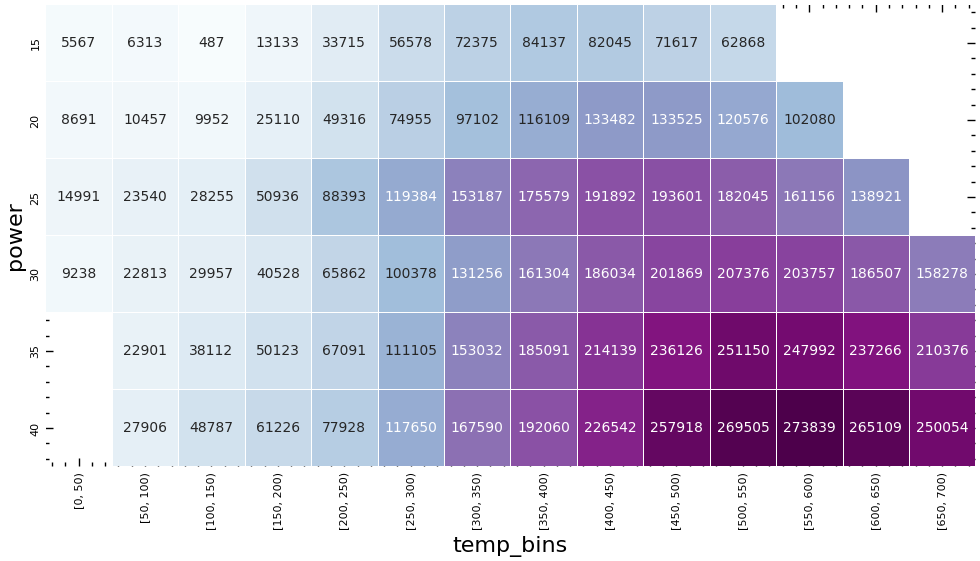

In [12]:
df['heat_loses'] = (df['calc_t'] - df['temperature']) * quartz_heat_capacity(df['calc_t'])

# Создаем интервалы температуры с шагом в 100 градусов
max_temp = int(df['temperature'].max())
df['temp_bins'] = pd.cut(df['temperature'], range(0, max_temp, 50), right=False)

# Группируем данные по 'power' и интервалам температуры, вычисляем среднее значение 'heat_loses'
mean_heat_loses = df.groupby(['power', 'temp_bins'])['heat_loses'].mean().unstack('temp_bins')

fig, axes = plt.subplots(figsize=(12, 6))
sns.heatmap(mean_heat_loses, cmap="BuPu", annot=True, fmt=".0f", linewidths=.5, cbar=False, ax=axes)
axes.tick_params(axis='x', labelsize=SMALL_SIZE)
axes.tick_params(axis='y', labelsize=SMALL_SIZE)
plt.show()

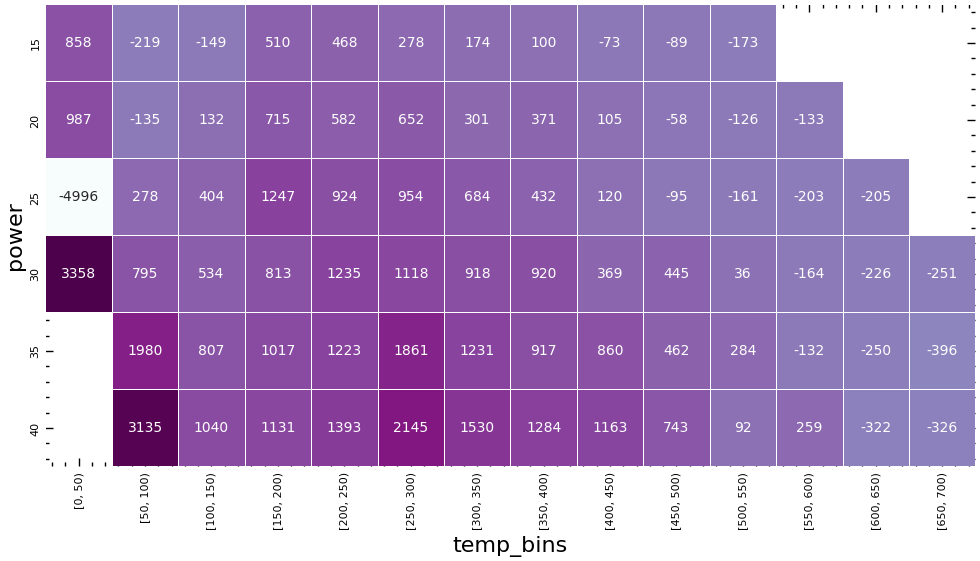

In [13]:
df['heat_loses_diff'] = df['heat_loses'].diff()

# Группируем данные по 'power' и интервалам температуры, вычисляем среднее значение 'heat_loses'
mean_heat_loses_diff = df.groupby(['power', 'temp_bins'])['heat_loses_diff'].mean().unstack('temp_bins')

fig, axes = plt.subplots(figsize=(12, 6))
sns.heatmap(mean_heat_loses_diff, cmap="BuPu", annot=True, fmt=".0f", linewidths=.5, cbar=False, ax=axes)
axes.tick_params(axis='x', labelsize=SMALL_SIZE)
axes.tick_params(axis='y', labelsize=SMALL_SIZE)
plt.show()

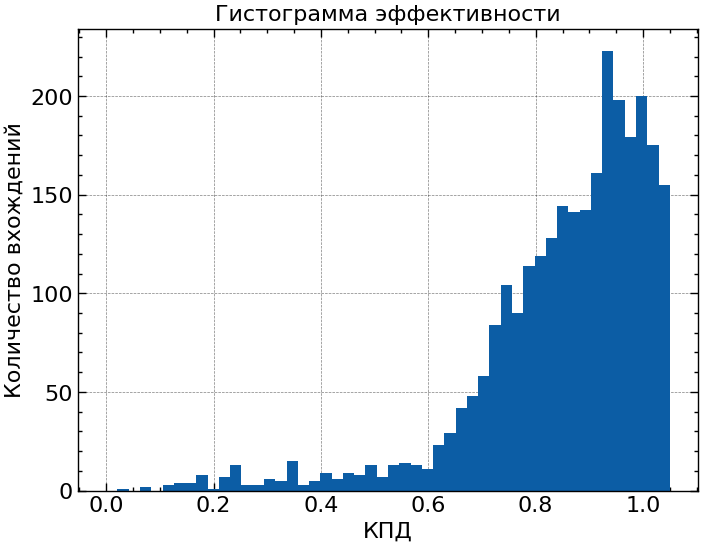

In [14]:
# Рассчитываем эффективность через отношение потерь тепла к тепловому потоку
df['efficiency'] = 1 - (df['heat_loses_diff'] / df['heat_flow'])

# Фильтруем строки с бесконечными или нечисловыми значениями эффективности
df = df[np.isfinite(df['efficiency'])]

# Строим гистограмму эффективности с заданными параметрами
df['efficiency'].hist(range=[0, 1.05], bins=50)

# Настраиваем параметры отображения графика и показываем его
plt.xlabel("КПД")
plt.ylabel("Количество вхождений")
plt.title("Гистограмма эффективности")
plt.show()

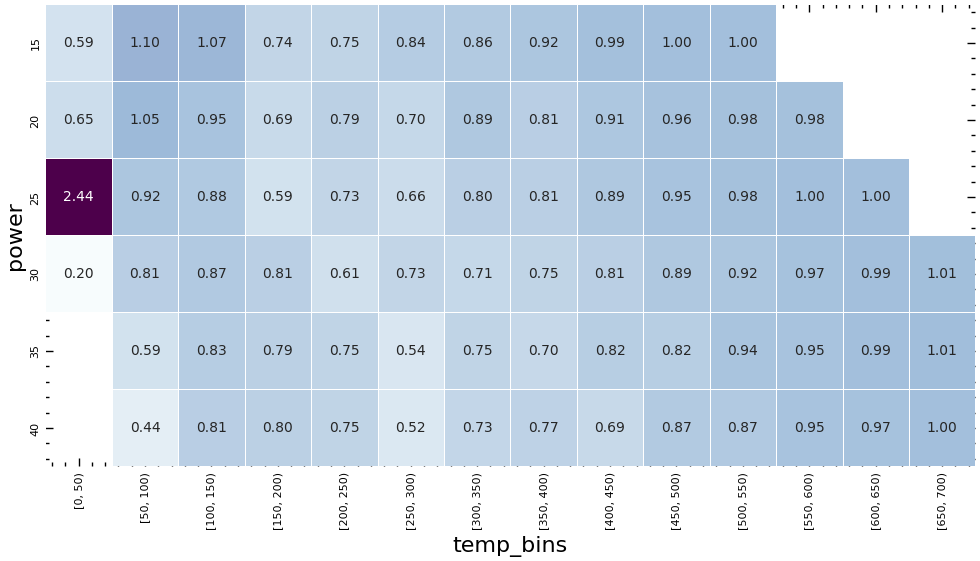

In [16]:
# Группируем данные по 'power' и интервалам температуры, вычисляем среднее значение 'heat_loses'
mean_heat_loses_diff = df.groupby(['power', 'temp_bins'])['efficiency'].mean().unstack('temp_bins')

fig, axes = plt.subplots(figsize=(12, 6))
sns.heatmap(mean_heat_loses_diff, cmap="BuPu", annot=True, fmt=".2f", linewidths=.5, cbar=False, ax=axes)
axes.tick_params(axis='x', labelsize=SMALL_SIZE)
axes.tick_params(axis='y', labelsize=SMALL_SIZE)
plt.show()